In [29]:
import tifffile, numpy
from skimage import data
from skimage import filters
from skimage import exposure
from scipy.spatial import distance
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
import segmentation_tools
import matplotlib.pyplot as plt  
import matplotlib
plt.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['figure.dpi'] = 100


In [2]:
def threshold_image( outname, channel_num, upper_lim, lower_lim, threshold=None ):
    a = tifffile.memmap( 'E:/MiRiEx/figures/fig 3/substacks_bl0/bl0_gephyrin_bassoon.tif' )
    b = numpy.array( a[:,channel_num,:,:].astype(numpy.int32) )
    
    if threshold is None:
        otsu_val = filters.threshold_otsu( b )
        threshold = otsu_val
    print( threshold )
    
    segmentation_tools.threshold_image( b, threshold )
    
    counts = segmentation_tools.flood_fill(b)
    new_counts = segmentation_tools.flood_threshold( b, counts, upper_lim, lower_lim )
   # test_counts = segmentation_tools.look_around( b, numpy.array(tifffile.memmap('Z:/fred/dec2019/3rdBatch_PVcreSecondImaging/bl0/substacks/r1_gephyrin.tif' )[:,0,:,:].astype(numpy.int32)), new_counts )
    new_counts_centroid = segmentation_tools.find_centroids( b, new_counts )
    
    print( channel_num, len( new_counts ) )
    
    tifffile.imwrite( outname, b.astype(numpy.uint16) )
    
    return new_counts, new_counts_centroid

In [3]:
def export_cut_image( outname, channel_num ):
    a = tifffile.memmap( 'E:/MiRiEx/figures/fig 3/substacks_bl0/bl0_gephyrin_bassoon.tif')
    b = numpy.array( a[:,channel_num,:,:].astype(numpy.int32) )
    
    tifffile.imwrite( outname, b.astype(numpy.uint16) )

In [153]:
syn_fn = 'Z:/fred/dec2019/3rdBatch_PVcreSecondImaging/bl0/nTracer/n26_synROI.csv'
with open(syn_fn, 'r', encoding='utf-8-sig') as f: 
    synData = numpy.genfromtxt(f, dtype=int, delimiter=',')

In [18]:
export_cut_image('temp_original_0.tif', 0 )
#export_cut_image( 'temp_original_1.tif', 1 )
#export_cut_image( 'temp_original_2.tif', 2 )

In [4]:
#Threshold image for gephyrin
gephyrin_counts, gephyrin_counts_centroid = threshold_image( 'temp_0.tif', 0, 1000, 30, threshold=6000 )
#bassoon_counts, bassoon_counts_centroid,test1 = threshold_image( 'temp_1.tif', 1, 400, 10, threshold=4500 )
#homer_counts, homer_counts_centroid, test2 = threshold_image( 'temp_2.tif', 2, 1500, 10, threshold=3000 )

6000
0 60068


In [81]:
syn_fn = 'Z:/fred/dec2019/3rdBatch_PVcreSecondImaging/bl0/nTracer/allSynROI.csv'
with open(syn_fn, 'r', encoding='utf-8-sig') as f: 
    synData = numpy.genfromtxt(f, dtype=int, delimiter=',')

listCentroids = numpy.array(list(gephyrin_counts_centroid.keys()))
listCentroids = listCentroids.astype(int)
listVolume = numpy.array(list(gephyrin_counts_centroid.values()))

listCentroids[:,[0,2]] = listCentroids[:,[2,0]] #Switch X,Y,Z order

ROIvolume = []

dist = distance.cdist(listCentroids,synData,'euclidean')

for i in range(0, len(synData)):
    idx = numpy.argmin(dist[:,i])
    if dist[idx,i] < 5:
        ROIvolume.append(listVolume[idx])
    else:
        ROIvolume.append(numpy.nan)
        
print(len(ROIvolume))
print(len(synData))

#Normalize volume by voxel size
ROIvolume= numpy.asarray(ROIvolume)*.000375

422
422


In [51]:
df1 = pd.DataFrame({"n1": ROIvolume_1})
df6 = pd.DataFrame({"n6": ROIvolume_6})
df26 = pd.DataFrame({"n26": ROIvolume_26})
df30 = pd.DataFrame({"n30": ROIvolume_30})
df37 = pd.DataFrame({"n37": ROIvolume_37})
df38 = pd.DataFrame({"n38": ROIvolume_38})
df47 = pd.DataFrame({"n47": ROIvolume_47})
df54 = pd.DataFrame({"n54": ROIvolume_54})

df = pd.concat([df1,df6, df26, df30,df37,df38, df47, df54],axis=1)
print(df)

          n1        n6       n26       n30       n37       n38      n47  \
0   0.069000  0.033375  0.046875  0.014625  0.012375  0.022875  0.15675   
1   0.045375  0.031125  0.031125  0.022500  0.022875  0.031875  0.06675   
2   0.111750  0.056250  0.046125  0.035250  0.036750  0.023625  0.06375   
3   0.105750  0.021750  0.035625  0.057750       NaN  0.023250  0.06375   
4   0.085500  0.025125  0.017625  0.015000       NaN  0.058875  0.04875   
..       ...       ...       ...       ...       ...       ...      ...   
79  0.093000       NaN       NaN       NaN       NaN       NaN      NaN   
80  0.121125       NaN       NaN       NaN       NaN       NaN      NaN   
81  0.145125       NaN       NaN       NaN       NaN       NaN      NaN   
82  0.086625       NaN       NaN       NaN       NaN       NaN      NaN   
83  0.234750       NaN       NaN       NaN       NaN       NaN      NaN   

         n54  
0   0.035625  
1   0.023625  
2   0.053625  
3   0.075375  
4   0.062625  
..       

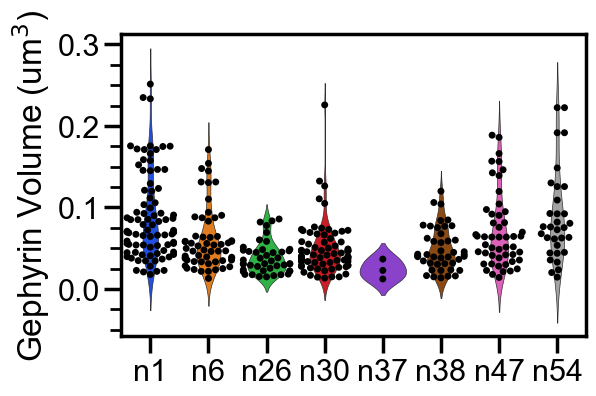

In [73]:
sns.set_context('poster')
ax = sns.violinplot(data = df,palette = 'bright', inner= None, linewidth = 0.5)

ax = sns.swarmplot(data = df, color = 'black')
ax.set_ylabel('Gephyrin Volume (um$^3$)')
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.025))

outname = 'E:/MiRiEx/figures/fig 4/allNeuronGephyrinVolume.svg'
plt.savefig(outname, dpi=300)

In [101]:
#code to add gephyrin volumes as a column onto a dataframe

df_fn = 'Z:/fred/dec2019/3rdBatch_PVcreSecondImaging/bl0/nTracer/allSynROI_df.csv';
allSyn_df = pd.read_csv(df_fn)
df_vol = pd.DataFrame({"volume": ROIvolume})
df = pd.concat([allSyn_df, df_vol],axis=1)

print(df)

     Axon  Neuron    volume
0       2       1  0.069000
1       2       1  0.045375
2       2       1  0.111750
3       2       1       NaN
4       2       1  0.105750
..    ...     ...       ...
417   194      38       NaN
418   195      38  0.084000
419   196      38       NaN
420    22      26  0.044625
421   176      26  0.038250

[422 rows x 3 columns]


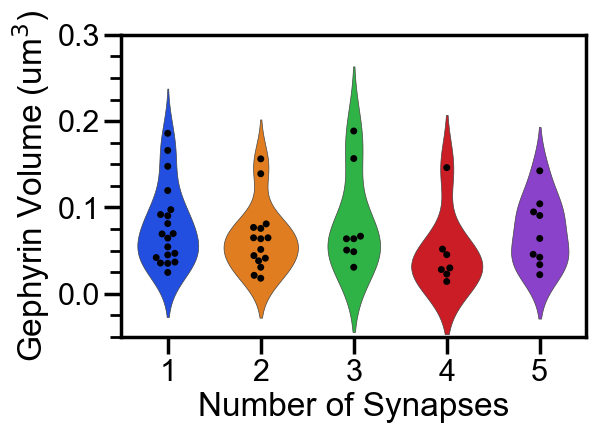

In [280]:
#Code for extracting out axons that synapse onto specific neuron and plot their volumes as a function of the number of synapses

neuronID = 47;

unique_axons = df['Axon'].groupby(df['Neuron']).unique().loc[neuronID] #For neuron 1

n1_df = pd.DataFrame(columns = [])

num_counts = df['Axon'].groupby(df['Neuron']).value_counts().loc[neuronID]
for n in unique_axons:
    num_volumes = df.loc[df['Axon']==n,['volume']].to_numpy()
    for z in num_volumes:
        n1_df = n1_df.append({str(num_counts[n]):z}, ignore_index = True)

n1_df = n1_df.reindex(sorted(n1_df.columns), axis =1)

sns.set_context('poster')
ax = sns.violinplot(data = n1_df,palette = 'bright', inner= None, linewidth = 0.5)
ax = sns.swarmplot(data = n1_df, color = 'black')
ax.set_ylabel('Gephyrin Volume (um$^3$)')
ax.set_xlabel('Number of Synapses')
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.025))
ax.set_ylim(-.05,.3)

outname = 'E:/MiRiEx/figures/fig 4/PSDvsSyn_neuron' +str(neuronID)+'.svg'
plt.savefig(outname, dpi=300)